In [1]:
pip install wrds

     |████████████████████████████████| 3.4MB 2.9MB/s 


In [2]:
import pandas as pd
import wrds

In [3]:
\conn=wrds.Connection()

# Get the members and the returns going out each month for the next quarter
sp500 = conn.raw_sql("""select base.*, m2.ret as ret_month_two, m3.ret as ret_month_three,
                            (1+ret_month_one)*(1+m2.ret)*(1+m3.ret)-1 as three_month_return
                        from 
                          (select a.*, b.date, b.ret as ret_month_one
                          from crsp.msp500list as a,
                          crsp.msf as b
                          where a.permno=b.permno
                          and b.date >= a.start and b.date<= a.ending
                          and b.date>='12/31/2009'
                          order by date) base
                          inner join (select date, 
                                            lead(date, 1) over (order by date) as next_month,
                                            lead(date, 2) over (order by date) as two_month
                                      from
                                      (select distinct date 
                                      from crsp.msf
                                      where date>='2009-01-01') as d) as dates
                            on base.date = dates.date
                          left join crsp.msf as m2
                            on base.permno = m2.permno
                            and dates.next_month = m2.date
                          left join crsp.msf as m3
                            on base.permno = m3.permno
                            and dates.two_month = m3.date
                          
                        """, date_cols=['start', 'ending', 'date'])


mse = conn.raw_sql("""
                        select comnam, ncusip, namedt, nameendt, 
                        permno, shrcd, exchcd, hsiccd, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

# Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                            & (sp500_full.date<=sp500_full.nameendt)]


### Add Compustat Identifiers
### - Link with Compustat's GVKEY and IID 

ccm=conn.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno,
                  linktype, linkprim, linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

# Merge the CCM data with S&P500 data
# First just link by matching PERMNO
sp500ccm = pd.merge(sp500_full, ccm, how='left', on=['permno'])

# Then set link date bounds
sp500ccm = sp500ccm.loc[(sp500ccm['date']>=sp500ccm['linkdt'])\
                        &(sp500ccm['date']<=sp500ccm['linkenddt'])]

# Rearrange columns for final output
sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', 'linktype', \
                                  'linkprim', 'linkdt', 'linkenddt'])
sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip',\
                     'shrcd', 'exchcd', 'hsiccd', 'ticker', \
                     'gvkey', 'iid', 'start', 'ending', 
                     'ret_month_one', 'ret_month_two',
                     'ret_month_three', 'three_month_return']]

Enter your WRDS username [root]:robertlouka
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [4]:
conn.close()

In [5]:
sp500ccm.head(20)

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret_month_one,ret_month_two,ret_month_three,three_month_return
0,2009-12-31,76712.0,A E S CORP,00130H10,11.0,1.0,4911.0,AES,024216,01,1998-10-02,2020-12-31,0.044741,-0.051089,-0.074426,-0.082418
1,2009-12-31,32870.0,HORMEL FOODS CORP,44045210,11.0,1.0,2011.0,HRL,005709,01,2009-03-04,2020-12-31,0.024787,0.011964,0.062274,0.101628
2,2009-12-31,76282.0,AUTONATION INC DEL,05329W10,11.0,1.0,5511.0,AN,009063,01,2003-02-24,2017-08-07,0.084986,-0.060052,-0.013889,0.005666
3,2009-12-31,77659.0,BED BATH & BEYOND INC,07589610,11.0,3.0,5700.0,BBBY,025338,01,1999-10-01,2017-07-25,0.033458,0.002331,0.075194,0.113758
4,2009-12-31,83699.0,TITANIUM METALS CORP,88833920,11.0,1.0,3341.0,TIE,062984,01,2007-10-29,2012-12-21,0.281474,-0.071086,0.013758,0.206755
5,2009-12-31,59192.0,CHUBB CORP,17123210,11.0,1.0,6331.0,CB,003024,01,1976-07-01,2016-01-15,-0.012166,0.016673,0.009200,0.013544
6,2009-12-31,89070.0,ZIMMER HOLDINGS INC,98956P10,11.0,1.0,3842.0,ZMH,144559,01,2001-08-07,2020-12-31,-0.001014,-0.047200,0.017933,-0.031097
7,2009-12-31,44951.0,SUPERVALU INC,86853610,11.0,1.0,5411.0,SVU,010190,01,1985-01-31,2012-04-30,-0.080983,0.157356,0.044018,0.110448
8,2009-12-31,11552.0,CELGENE CORP,15102010,11.0,3.0,2890.0,CELG,013599,01,2006-11-06,2019-11-20,0.004148,0.019756,0.048256,0.073399
9,2009-12-31,10138.0,T ROWE PRICE GROUP INC,74144T10,11.0,3.0,6211.0,TROW,012138,01,1999-10-13,2020-12-31,0.093399,-0.068169,0.021564,0.040833


In [6]:
counts_df = sp500ccm[['ticker', 'date']].groupby(by='date').agg('count')

In [7]:
counts_df.head()

,ticker
date,
2009-12-31,501
2010-01-29,501
2010-02-26,500
2010-03-31,501
2010-04-30,501


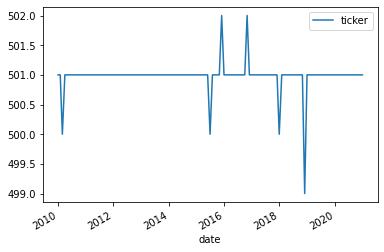

In [8]:
counts_df.plot()

In [9]:
sp500ccm.to_csv(r'sp500ccm.csv')